In [0]:
#download the dataset
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
#unzip the dataset
!unzip tiny-imagenet-200.zip

Output hidden; open in https://colab.research.google.com to view.

In [13]:
#prepare val data classes to file relation
import pandas as pd
val_data = pd.read_csv('./tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head()

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727
3,val_3.JPEG,n02808440
4,val_4.JPEG,n02808440


In [14]:
!ls

sample_data  tiny-imagenet-200	tiny-imagenet-200.zip


In [0]:
# Use Augmentaion parameters as required.
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=60,
    horizontal_flip=True,
    shear_range=0.2,
    fill_mode='nearest'
    )

valid_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
#initialize train and val data generator
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=500, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=200, shuffle=True, seed=42)

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


In [0]:
#visualize images from the dataset
def visualize_image(path):
  %matplotlib inline
  %pylab inline
  import matplotlib.pyplot as plt
  import matplotlib.image as mpimg
  img=mpimg.imread(path)
  imgplot = plt.imshow(img)
  plt.show()

In [34]:
from __future__ import division

import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.
        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved
        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)
        
        
        final_layer = Conv2D(num_outputs, (1,1), strides=(1,1), name='conv_1x1', use_bias=False)(block)
        
#         # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]), strides=(1, 1))(final_layer)
        flatten1 = Flatten()(pool2)
        output = Activation('softmax')(flatten1)
        
#         final_layer = Conv2D(num_outputs, (1,1), strides=(1,1), name='conv_1x1', use_bias=False)(flatten1)
# #         dense = Dense(units=num_outputs, kernel_initializer="he_normal",activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=output)
        return model

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])
      
model = ResnetBuilder.build_resnet_50((3,64,64),200)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 32, 32, 64)   9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_246 (BatchN (None, 32, 32, 64)   256         conv2d_266[0][0]                 
__________________________________________________________________________________________________
activation_250 (Activation)     (None, 32, 32, 64)   0           batch_normalization_246[0][0]    
__________________________________________________________________________________________________
max_poolin

In [0]:

from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os

dir_path = os.listdir('/content/gdrive/My Drive/EIP3.0')
print(dir_path)

model.save_weights("/content/gdrive/My Drive/EIP3.0/model_"+str(epoch)+"_"+str(results[1])+".h5")
print("Saved model to disk")

['Assignment 2A2B.ipynb', 'Assignment 3B.ipynb', '1st DNN.ipynb', 'Assignment 3C.ipynb', 'weights-improvement-13-0.15.hdf5', 'model.json']
Saved model to disk


In [0]:
from keras import optimizers

clr_triangular = CyclicLR(mode='triangular')

epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
# sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])

In [37]:
for epoch in range(epochs):  
  model.fit_generator(train_generator,epochs=1, callbacks=[clr_triangular], samples_per_epoch = 100000, verbose=1)
  if epoch % 10 == 0:
    results = model.evaluate_generator(validation_generator, steps=1) 
    print("epoch "+str(epoch)+" of "+str(epochs))
    print('Accuracy :', (results[1]*100.0))

    
model.save_weights("/content/gdrive/My Drive/EIP3.0/model_64x64_"+str(epoch)+"_"+str(results[1])+".h5")
print("Saved model to disk")

# model.save_weights("./EIP3.0/model_"+epcoch+"_"+results+".h5")
# print("Saved model to disk")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=1, callbacks=[<__main__..., verbose=1, steps_per_epoch=200)`
  


Epoch 1/1
200/200 [==============================] - 276s 1s/step - loss: 10.5998 - acc: 0.0135
epoch 0 of 50
Accuracy : 2.500000037252903
Epoch 1/1
200/200 [==============================] - 270s 1s/step - loss: 10.3468 - acc: 0.0321
Epoch 1/1
200/200 [==============================] - 270s 1s/step - loss: 10.1818 - acc: 0.0459
Epoch 1/1
200/200 [==============================] - 269s 1s/step - loss: 10.0568 - acc: 0.0567
Epoch 1/1
200/200 [==============================] - 270s 1s/step - loss: 9.9555 - acc: 0.0652
Epoch 1/1
200/200 [==============================] - 269s 1s/step - loss: 9.8584 - acc: 0.0753
Epoch 1/1
200/200 [==============================] - 269s 1s/step - loss: 9.7608 - acc: 0.0844
Epoch 1/1
200/200 [==============================] - 269s 1s/step - loss: 9.6685 - acc: 0.0946
Epoch 1/1
200/200 [==============================] - 268s 1s/step - loss: 9.5617 - acc: 0.1042
Epoch 1/1
200/200 [==============================] - 270s 1s/step - loss: 9.4577 - acc: 0.1132
Epo

In [0]:
#load weights to model
model.load_weights("/content/gdrive/My Drive/EIP3.0/model_49_0.18000000715255737.h5")


In [0]:
from keras import optimizers

clr_triangular = CyclicLR(mode='triangular')

epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
# sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])
epochs = 100
for epoch in range(epochs):  
  print("50 to 150 epochs")
  model.fit_generator(train_generator,epochs=1, callbacks=[clr_triangular], samples_per_epoch = 100000, verbose=1)
  if epoch % 10 == 0:
    results = model.evaluate_generator(validation_generator, steps=1) 
    print('Accuracy :', (results[1]*100.0))


model.save_weights("/content/gdrive/My Drive/EIP3.0/model_"+str(epoch)+"_"+str(results[1])+".h5")
print("Saved model to disk")


50 to 150 epochs


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., epochs=1, callbacks=[<__main__..., verbose=1, steps_per_epoch=200)`


Epoch 1/1
200/200 [==============================] - 157s 786ms/step - loss: 7.9973 - acc: 0.2429
Accuracy : 17.499999701976776
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 153s 765ms/step - loss: 7.9788 - acc: 0.2473
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 153s 767ms/step - loss: 7.9631 - acc: 0.2476
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 153s 766ms/step - loss: 7.9449 - acc: 0.2495
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 153s 765ms/step - loss: 7.9487 - acc: 0.2472
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 153s 763ms/step - loss: 7.9146 - acc: 0.2499
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 152s 762ms/step - loss: 7.8949 - acc: 0.2493
50 to 150 epochs
Epoch 1/1
200/200 [==============================] - 152s 762ms/step - loss: 7.8694 - acc: 0.2518
50 to 150 epochs
Epoch 1/1
200/200 [==============================]

In [0]:
#initialize train and val data generator
train_generator = train_datagen.flow_from_directory( r'./tiny-imagenet-200/train/', target_size=(64, 64), color_mode='rgb', 
                                                    batch_size=500, class_mode='categorical', shuffle=True, seed=42)
validation_generator = valid_datagen.flow_from_dataframe(val_data, directory='./tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=(64, 64),
                                                    color_mode='rgb', class_mode='categorical', batch_size=200, shuffle=True, seed=42)

model = ResnetBuilder.build_resnet_50((3,64,64),200)
#load weights to model
model.load_weights("/content/gdrive/My Drive/EIP3.0/model_99_0.12999999523162842.h5")

from keras import optimizers

clr_triangular = CyclicLR(mode='triangular')

epochs = 50
learning_rate = 0.01
decay_rate = learning_rate / epochs
momentum = 0.9
# sgd = optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
             optimizer=sgd,
             metrics=['accuracy'])
epochs = 100
for epoch in range(epochs):  
  print("150 to 250 epochs")
  model.fit_generator(train_generator,epochs=1, callbacks=[clr_triangular], samples_per_epoch = 100000, verbose=1)
  if epoch % 10 == 0:
    results = model.evaluate_generator(validation_generator, steps=1) 
    print('Accuracy :', (results[1]*100.0))


model.save_weights("/content/gdrive/My Drive/EIP3.0/model_"+str(epoch)+"_"+str(results[1])+".h5")
print("Saved model to disk")

Found 100000 images belonging to 200 classes.
Found 10000 images belonging to 200 classes.


ValueError: ignored

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


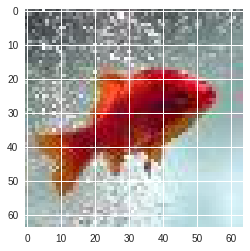

In [0]:
Avisualize_image('tiny-imagenet-200/train/n01443537/images/n01443537_10.JPEG')

In [0]:
!@optimize for a wider network --> more number of channels/kernels

32 -> 64 -> 128 -> 256 -> 512 
64 -> 128 -> 256 -> 512 -> 1024
128 -> 256 -> 512 -> 1024 -> 2048


32 x 32 x 3
30 x 30 x 3 x 32
28 x 28 x 3 x 64
26 x 26 x 3 x 128
24 x 24 x 3 x 256
22 x 22 x 3 x 512


occlusion - image augmentation
https://github.com/mdbloice/Augmentor
https://medium.com/@arindambaidya168/https-medium-com-arindambaidya168-using-keras-imagedatagenerator-b94a87cdefad
  
  
rewrite the model 
gradient descent with momentum

validate every 10 epochs
re-write the data generator

first 50 epochs with 16x16
next 100 with 32x32
next 100 with 64x64
model checkpoint and restore with varying input sizes